# Lazy loading ensembles

When each ensemble contains huge amount of models & large data set or the ensemble amount is large (e.g., > 50), it might not be viable to load all ensembles into memory. In that case, we can ask the model to save all ensembles into disk, and only load them when the ensembles are being used. This process may dramatically reduce the memory usage but also reduce the speed of prediction, since the IO (read & write between disk and memory) will be a speed limit here.


We run experiments to see how this speed-memory trade-off works:

In [2]:
import os
import sys 

import pandas as pd
import numpy as np
import random
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import matplotlib
import warnings
import pickle
import h3pandas
import copy
import gc

pd.set_option('display.max_columns', None)
# warnings.filterwarnings('ignore')


In [3]:
%load_ext autoreload
%autoreload 2

## Download data

### Training/test data

Please download the sample data from:<br>
- Mallard: https://figshare.com/articles/dataset/Sample_data_Mallard_csv/24080745<br>

Suppose now it's downloaded and saved as './Sample_data_Mallard.csv'<br>

Alternatively, you can try other species like <br>
- Alder Flycatcher: https://figshare.com/articles/dataset/Sample_data_Alder_Flycatcher_csv/24080751<br>
- Short-eared Owl: https://figshare.com/articles/dataset/Sample_data_Short-eared_Owl_csv/24080742<br>
- Eurasian Tree Sparrow: https://figshare.com/articles/dataset/Sample_data_Eurasian_Tree_Sparrow_csv/24080748<br>

**Caveat: These bird observation data are about 200MB each file.**

In [3]:
data = pd.read_csv(f'./Sample_data_Mallard.csv')
data = data.drop('sampling_event_identifier', axis=1)


In [4]:
data = data.sample(frac=0.7)

### Prediction set

Prediction set are used to feed into a trained AdaSTEM model and make prediction: at some location, at some day of year, given the environmental variables, how many Mallard individual do I expected to observe?

The prediction set will be loaded after the model is trained.

Download the prediction set from: https://figshare.com/articles/dataset/Predset_2020_csv/24124980

**Caveat: The file is about 700MB.**

## Get X and y

In [5]:
X = data.drop('count', axis=1)
y = data[['count']]


In [6]:
X.head()

,longitude,latitude,DOY,duration_minutes,Traveling,Stationary,Area,effort_distance_km,number_observers,obsvr_species_count,time_observation_started_minute_of_day,elevation_mean,slope_mean,eastness_mean,northness_mean,bio1,bio2,bio3,bio4,bio5,bio6,bio7,bio8,bio9,bio10,bio11,bio12,bio13,bio14,bio15,bio16,bio17,bio18,bio19,closed_shrublands,cropland_or_natural_vegetation_mosaics,croplands,deciduous_broadleaf_forests,deciduous_needleleaf_forests,evergreen_broadleaf_forests,evergreen_needleleaf_forests,grasslands,mixed_forests,non_vegetated_lands,open_shrublands,permanent_wetlands,savannas,urban_and_built_up_lands,water_bodies,woody_savannas,entropy
263175,-123.019044,47.858353,195,7.0,1,0,0,0.37,1.0,128.0,778,1110.722200,18.219984,0.011649,0.089834,10.357637,6.032252,29.674278,541.989926,21.865567,1.537348,20.328219,4.168856,18.101185,17.786334,4.306112,0.236358,0.044619,0.006454,0.000098,0.096307,0.024372,0.029845,0.093691,0.0,0.0,0.000000,0.0,0.0,0.0,0.916667,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083333,0.286836
280085,12.473688,55.922807,20,240.0,0,1,0,-1.00,1.0,1352.0,495,15.388889,0.565277,0.134130,0.318295,10.058796,5.818570,28.670519,525.063282,23.219485,2.924875,20.294610,4.399586,7.581833,17.380332,4.169970,0.094377,0.012997,0.002858,0.000008,0.033297,0.012446,0.026897,0.026974,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.027778,0.0,0.000000,0.000000,0.027778,0.000000,0.916667,0.027778,0.000000,0.378387
112684,-2.431044,37.068092,189,41.0,1,0,0,0.61,1.0,824.0,1267,577.500000,4.710071,-0.163467,0.133471,17.773978,9.253330,34.638289,570.883930,32.073045,5.358878,26.714167,13.548977,26.818733,25.499594,11.202012,0.033857,0.007722,0.000086,0.000008,0.020974,0.000483,0.002288,0.006723,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.805556,0.0,0.027778,0.027778,0.000000,0.000000,0.138889,0.000000,0.000000,0.647442
265414,-110.020510,40.432903,146,7.0,0,1,0,-1.00,1.0,507.0,519,1848.000000,1.490136,0.106562,-0.966846,9.715427,13.209330,28.637380,1110.109971,33.798837,-12.327343,46.126180,3.553384,25.946747,23.779383,-4.921639,0.023079,0.004478,0.000293,0.000002,0.011060,0.001562,0.004894,0.005137,0.0,0.0,0.222222,0.0,0.0,0.0,0.000000,0.666667,0.0,0.000000,0.000000,0.000000,0.000000,0.111111,0.000000,0.000000,0.848686
214723,-115.765366,49.502519,2,5.0,1,0,0,0.30,1.0,208.0,673,926.666700,1.435143,0.079117,0.243562,5.719074,8.978106,26.744377,852.675824,25.758665,-7.811405,33.570070,-2.597283,19.475712,17.455207,-4.053263,0.071918,0.010628,0.001074,0.000009,0.029174,0.005960,0.005960,0.024750,0.0,0.0,0.000000,0.0,0.0,0.0,0.638889,0.000000,0.0,0.000000,0.000000,0.000000,0.027778,0.000000,0.000000,0.333333,0.751984


The features include:

- spatial coordinates:
  - `longitude` and `latitude` (used for indexing, not actual training)
    
- Temporal coordinate:
  - day of year (`DOY`): used for both indexing and training

- Sampling parameters: These are parameters quantifying how the observation was made
  - `duration_minutes`: How long the observation was conducted
  - Observation protocol: `Traveling`, `Stationary`, or `Area`
  -  `effort_distance_km`: how far have one traveled
  -  `number_observers`: How many observers are there in the group
  - `obsvr_species_count`: How many bird species have the birder observed in the past
  - `time_observation_started_minute_of_day`: When did the birder start birding

- Topological features:
  - Features of elevation: `elevation_mean`
  - Features of slope magnitude and direction: `slope_mean`, `eastness_mean`, `northness_mean`

- Bioclimate features:
  - Summaries of yearly temperature and precipitation: from `bio1` to `bio19`

- Land cover features:
  - Summaries of land cover, percentage of cover. For example, `closed_shrublands`,  `urban_and_built_up_lands`.
  - `entropy`: Entropy of land cover


As you can see, the environmental variables are almost static. However, dynamic features (e.g., daily temperature) is fully supported as input. See [Tips for data types](https://chenyangkang.github.io/stemflow/Tips/Tips_for_data_types.html) for details.
  
  
 

## First thing first: Spatiotemporal train test split

In [7]:
from stemflow.model_selection import ST_train_test_split
X_train, X_test, y_train, y_test = ST_train_test_split(X, y, 
                                                        Spatio1 = 'longitude',
                                                        Spatio2 = 'latitude',
                                                        Temporal1 = 'DOY',
                                                        Spatio_blocks_count = 50, Temporal_blocks_count=50,
                                                        random_state=42, test_size=0.3)


## Initiate AdaSTEM hurdle model

In [8]:
from stemflow.model.AdaSTEM import AdaSTEM, AdaSTEMClassifier, AdaSTEMRegressor
from xgboost import XGBClassifier, XGBRegressor # remember to install xgboost if you use it as base model
from stemflow.model.Hurdle import Hurdle_for_AdaSTEM, Hurdle


In [ ]:
import os, time, threading, psutil

class PeakRSSMonitor:
    def __init__(self, interval=0.05, include_children=True):
        self.interval = interval
        self.include_children = include_children
        self._stop = threading.Event()
        self.samples = []

    def _collect(self):
        p = psutil.Process(os.getpid())
        while not self._stop.is_set():
            rss = p.memory_info().rss
            if self.include_children:
                for c in p.children(recursive=True):
                    try:
                        rss += c.memory_info().rss
                    except psutil.NoSuchProcess:
                        pass
            self.samples.append(rss / (1024**3))  # GB
            time.sleep(self.interval)

    def __enter__(self):
        self._t = threading.Thread(target=self._collect, daemon=True)
        self._t.start()
        return self

    def __exit__(self, exc_type, exc, tb):
        self._stop.set()
        self._t.join()

    @property
    def peak(self): 
        return max(self.samples) if self.samples else 0.0

    @property
    def average(self): 
        return (sum(self.samples) / len(self.samples)) if self.samples else 0.0
    


In [16]:
import time
from memory_profiler import memory_usage

def make_model_lazyloading(ensemble_fold, n_jobs=3):
    model_lazyloading = AdaSTEMRegressor(
        base_model=Hurdle(
            classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
            regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
        ),                                      # hurdel model for zero-inflated problem (e.g., count)
        task='hurdle',
        save_gridding_plot = True,
        ensemble_fold=ensemble_fold,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
        min_ensemble_required=ensemble_fold-2,                # Only points covered by > 7 ensembles will be predicted
        grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
        grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
        temporal_start=1,                       # The next 4 params define the temporal sliding window
        temporal_end=366,                            
        temporal_step=25,                       # The window takes steps of 20 DOY (see AdaSTEM demo for details)
        temporal_bin_interval=50,               # Each window will contain data of 50 DOY
        points_lower_threshold=50,              # Only stixels with more than 50 samples are trained
        Spatio1='longitude',                    # The next three params define the name of 
        Spatio2='latitude',                     # spatial coordinates shown in the dataframe
        Temporal1='DOY',
        use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
        n_jobs=n_jobs,                               # Using parallel computing
        random_state=42,                        # The random state makes the gridding process reproducible
        lazy_loading=True,                       # Using lazy loading for large ensemble amount (e.g., >20 ensembles). 
        verbosity=1                              # -- Each trained ensemble will be saved into disk and will only be loaded if needed (e.g. for prediction).
    )
    
    return model_lazyloading


def make_model_not_lazyloading(ensemble_fold, n_jobs=3):
    model_not_lazyloading = AdaSTEMRegressor(
        base_model=Hurdle(
            classifier=XGBClassifier(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1),
            regressor=XGBRegressor(tree_method='hist',random_state=42, verbosity = 0, n_jobs=1)
        ),                                      # hurdel model for zero-inflated problem (e.g., count)
        task='hurdle',
        save_gridding_plot = True,
        ensemble_fold=ensemble_fold,                       # data are modeled 10 times, each time with jitter and rotation in Quadtree algo
        min_ensemble_required=ensemble_fold-2,                # Only points covered by > 7 ensembles will be predicted
        grid_len_upper_threshold=25,            # force splitting if the grid length exceeds 25
        grid_len_lower_threshold=5,             # stop splitting if the grid length fall short 5         
        temporal_start=1,                       # The next 4 params define the temporal sliding window
        temporal_end=366,                            
        temporal_step=25,                       # The window takes steps of 20 DOY (see AdaSTEM demo for details)
        temporal_bin_interval=50,               # Each window will contain data of 50 DOY
        points_lower_threshold=50,              # Only stixels with more than 50 samples are trained
        Spatio1='longitude',                    # The next three params define the name of 
        Spatio2='latitude',                     # spatial coordinates shown in the dataframe
        Temporal1='DOY',
        use_temporal_to_train=True,             # In each stixel, whether 'DOY' should be a predictor
        n_jobs=n_jobs,                               # Using parallel computing
        random_state=42,                        # The random state makes the gridding process reproducible
        lazy_loading=False,                       # Using lazy loading for large ensemble amount (e.g., >20 ensembles). 
        verbosity=1                               # -- Each trained ensemble will be saved into disk and will only be loaded if needed (e.g. for prediction).
    )
    return model_not_lazyloading

def train_model(model, X_train, y_train):
    
    start_time = time.time()

    gc.collect()
    p = psutil.Process(os.getpid())
    baseline = p.memory_info().rss / 1e9

    with PeakRSSMonitor(interval=0.05, include_children=True) as mon:
        model.fit(X_train, y_train)

    peak_use = mon.peak - baseline
    average_use = mon.average - baseline

    end_time = time.time()
    
    training_time_use = end_time - start_time
    print('Training finish!')
    
    return training_time_use, peak_use, average_use
    
def test_model(model, X_test, y_test):
    
    start_time = time.time()
    
    gc.collect()
    p = psutil.Process(os.getpid())
    baseline = p.memory_info().rss / 1e9

    with PeakRSSMonitor(interval=0.05, include_children=True) as mon:
        res = model.predict(X_test)

    peak_use = mon.peak - baseline
    average_use = mon.average - baseline
    
    end_time = time.time()
    
    prediction_time_use = end_time - start_time
    print('Prediction finish!')
    
    return prediction_time_use, peak_use, average_use



## Run test: Same n_jobs, increasing ensembles

In [11]:
log_list=[]

In [12]:
ensemble_fold_list = [3, 5, 10, 20, 30, 40]

for ensemble_fold in tqdm(ensemble_fold_list):
    
    model_not_lazyloading = make_model_not_lazyloading(ensemble_fold)
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_not_lazyloading, X_train, y_train)
    test_time_use, peak_test_memory_use, average_test_memory_use = test_model(model_not_lazyloading, X_test, y_test)
    
    log_list.append({
        'ensemble_fold':ensemble_fold,
        'lazy_loading':False,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use,
        'test_time_use':test_time_use,
        'peak_test_memory_use':peak_test_memory_use,
        'average_test_memory_use':average_test_memory_use
    })
    
    del model_not_lazyloading
    
    model_lazyloading = make_model_lazyloading(ensemble_fold)
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, X_train, y_train)
    test_time_use, peak_test_memory_use, average_test_memory_use = test_model(model_lazyloading, X_test, y_test)
    
    log_list.append({
        'ensemble_fold':ensemble_fold,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use,
        'test_time_use':test_time_use,
        'peak_test_memory_use':peak_test_memory_use,
        'average_test_memory_use':average_test_memory_use
    })
    
    del model_lazyloading
    
    

  0%|          | 0/6 [00:00<?, ?it/s]

Training: 100%|██████████| 3/3 [00:48<00:00, 16.11s/it]


Training finish!


Predicting: 100%|██████████| 3/3 [00:16<00:00,  5.66s/it]


Prediction finish!


Training: 100%|██████████| 3/3 [00:47<00:00, 15.96s/it]


Training finish!


Predicting: 100%|██████████| 3/3 [00:07<00:00,  2.44s/it]


Prediction finish!


Training: 100%|██████████| 5/5 [01:33<00:00, 18.75s/it]


Training finish!


Predicting: 100%|██████████| 5/5 [00:35<00:00,  7.05s/it]


Prediction finish!


Training: 100%|██████████| 5/5 [01:33<00:00, 18.69s/it]


Training finish!


Predicting: 100%|██████████| 5/5 [00:13<00:00,  2.68s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [03:01<00:00, 18.11s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [01:57<00:00, 11.75s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [03:01<00:00, 18.15s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [00:24<00:00,  2.44s/it]


Prediction finish!


Training: 100%|██████████| 20/20 [05:20<00:00, 16.03s/it]


Training finish!


Predicting: 100%|██████████| 20/20 [07:48<00:00, 23.45s/it]


Prediction finish!


Training: 100%|██████████| 20/20 [05:22<00:00, 16.10s/it]


Training finish!


Predicting: 100%|██████████| 20/20 [00:44<00:00,  2.23s/it]


Prediction finish!


Training: 100%|██████████| 30/30 [07:39<00:00, 15.33s/it]


Training finish!


Predicting: 100%|██████████| 30/30 [17:49<00:00, 35.64s/it]


Prediction finish!


Training: 100%|██████████| 30/30 [07:43<00:00, 15.47s/it]


Training finish!


Predicting: 100%|██████████| 30/30 [01:05<00:00,  2.19s/it]


Prediction finish!


Training: 100%|██████████| 40/40 [10:30<00:00, 15.76s/it]


Training finish!


Predicting: 100%|██████████| 40/40 [43:10<00:00, 64.77s/it]


Prediction finish!


Training: 100%|██████████| 40/40 [10:44<00:00, 16.12s/it]


Training finish!


Predicting: 100%|██████████| 40/40 [01:29<00:00,  2.24s/it]


Prediction finish!


In [13]:
log_df = pd.DataFrame(log_list)
log_df.to_csv('tmp_log_df.csv', index=False)
log_df

,ensemble_fold,lazy_loading,train_time_use,peak_train_memory_use,average_train_memory_use,test_time_use,peak_test_memory_use,average_test_memory_use
0,3,False,50.806091,3.476909,2.150110,17.455705,4.897534,2.852421
1,3,True,50.336192,2.229499,1.954478,7.834628,1.326746,1.011839
2,5,False,97.274158,4.095497,2.708906,35.830203,7.564695,4.309321
3,5,True,96.999580,2.317293,2.045324,13.908911,1.299087,1.067382
4,10,False,186.838682,5.158661,3.498526,118.242545,10.935197,6.431464
5,10,True,187.569370,2.463759,2.195400,25.011556,1.476489,1.277835
6,20,False,329.970285,5.937576,3.976648,469.818361,10.985673,5.102644
7,20,True,331.527024,2.786055,2.521127,45.129958,1.862465,1.635676
8,30,False,472.763059,7.879175,4.926831,1070.444758,17.379095,7.252891
9,30,True,477.305425,2.766816,2.533723,66.458584,1.906993,1.708537


### Plotting experiment results

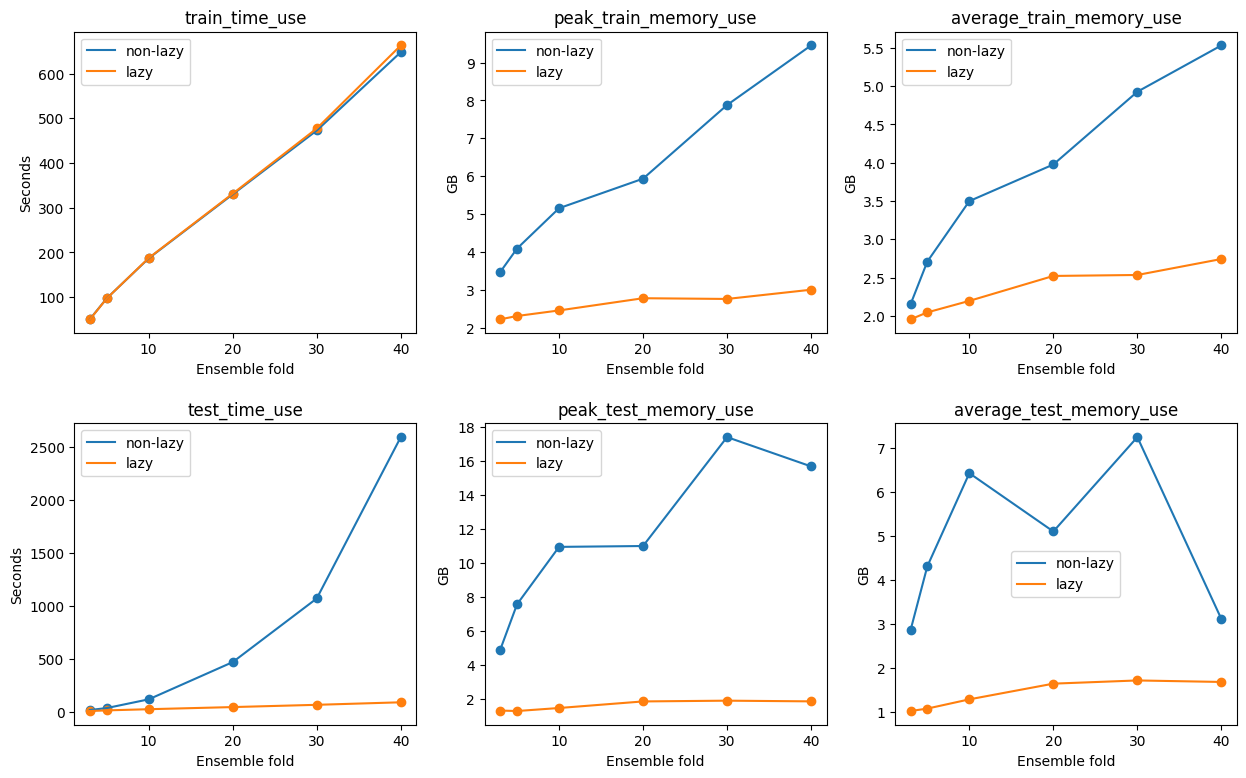

In [14]:
fig,ax = plt.subplots(2,3,figsize=(15,9))
for var_id, var_ in enumerate(['train_time_use','peak_train_memory_use','average_train_memory_use',
             'test_time_use','peak_test_memory_use','average_test_memory_use']):
    ax[var_id//3, var_id%3].plot(
        log_df[log_df['lazy_loading']==False]['ensemble_fold'],
        log_df[log_df['lazy_loading']==False][var_],
        label='non-lazy'
    )
    ax[var_id//3, var_id%3].scatter(
        log_df[log_df['lazy_loading']==False]['ensemble_fold'],
        log_df[log_df['lazy_loading']==False][var_],
    )

    ax[var_id//3, var_id%3].plot(
        log_df[log_df['lazy_loading']==True]['ensemble_fold'],
        log_df[log_df['lazy_loading']==True][var_],
        label='lazy'
    )
    ax[var_id//3, var_id%3].scatter(
        log_df[log_df['lazy_loading']==True]['ensemble_fold'],
        log_df[log_df['lazy_loading']==True][var_],
    )

    ax[var_id//3, var_id%3].legend()
    ax[var_id//3, var_id%3].set_title(var_)
    if 'time' in var_:
        ax[var_id//3, var_id%3].set_ylabel('Seconds')
    elif 'memory' in var_:
        ax[var_id//3, var_id%3].set_ylabel('GB')
    ax[var_id//3, var_id%3].set_xlabel('Ensemble fold')


plt.subplots_adjust(wspace=0.2, hspace=0.3)


### Speed vs. memory usage

From the results we can clearly see the trade-off. Using lazy-loading:
1. It is so interesting that lazy-loading seems to even reduce the prediction time. This could be due to two reasons: (1) A lazy-loading model does not load unnecessary models an only focus on certain stixels that cover the needed points, and (2) joblib does not need to serialize a huge amount of data (models) which saves so much time.
2. Has large impact on testing (prediction) speed. The time for prediction is more than doubled in our case.
3. Lazy-loading will maintain memory-use stable and unchanged as ensemble fold increases (maintaining ~ 3GB in our case), while non-lazy-loading will have linear memory consumption growth.

## Run test: Same ensemble fold, different n_jobs parallel

In [17]:
log_list=[]

In [20]:
n_jobs_list = [1, 3, 5, 8, 10]

for n_jobs in tqdm(n_jobs_list):
    
    model_not_lazyloading = make_model_not_lazyloading(ensemble_fold=10, n_jobs=n_jobs)
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_not_lazyloading, X_train, y_train)
    test_time_use, peak_test_memory_use, average_test_memory_use = test_model(model_not_lazyloading, X_test, y_test)
    
    log_list.append({
        'n_jobs':n_jobs,
        'lazy_loading':False,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use,
        'test_time_use':test_time_use,
        'peak_test_memory_use':peak_test_memory_use,
        'average_test_memory_use':average_test_memory_use
    })
    
    del model_not_lazyloading
    
    model_lazyloading = make_model_lazyloading(ensemble_fold=10, n_jobs=n_jobs)
    train_time_use, peak_train_memory_use, average_train_memory_use = train_model(model_lazyloading, X_train, y_train)
    test_time_use, peak_test_memory_use, average_test_memory_use = test_model(model_lazyloading, X_test, y_test)
    
    log_list.append({
        'n_jobs':n_jobs,
        'lazy_loading':True,
        'train_time_use':train_time_use,
        'peak_train_memory_use':peak_train_memory_use,
        'average_train_memory_use':average_train_memory_use,
        'test_time_use':test_time_use,
        'peak_test_memory_use':peak_test_memory_use,
        'average_test_memory_use':average_test_memory_use
    })
    
    del model_lazyloading
    
    

  0%|          | 0/5 [00:00<?, ?it/s]

Training: 100%|██████████| 10/10 [07:39<00:00, 45.95s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [00:24<00:00,  2.41s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [08:30<00:00, 51.04s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [01:12<00:00,  7.25s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [03:08<00:00, 18.84s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [01:57<00:00, 11.73s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [03:09<00:00, 19.00s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [00:26<00:00,  2.68s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [01:45<00:00, 10.58s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [02:00<00:00, 12.04s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [01:44<00:00, 10.42s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [00:14<00:00,  1.46s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [01:48<00:00, 10.89s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [02:01<00:00, 12.17s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [01:43<00:00, 10.38s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [00:16<00:00,  1.69s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [01:15<00:00,  7.52s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [02:03<00:00, 12.32s/it]


Prediction finish!


Training: 100%|██████████| 10/10 [01:12<00:00,  7.21s/it]


Training finish!


Predicting: 100%|██████████| 10/10 [00:12<00:00,  1.30s/it]


Prediction finish!


In [7]:
log_df = pd.DataFrame(log_list)
log_df.to_csv('tmp_log_df_for_n_jobs.csv', index=False)
log_df

,n_jobs,lazy_loading,train_time_use,peak_train_memory_use,average_train_memory_use,test_time_use,peak_test_memory_use,average_test_memory_use
0,1,False,472.504835,1.533439,0.715229,24.415852,-0.198594,-0.205163
1,1,True,524.037611,-0.221716,-0.257094,72.783562,-0.217577,-0.222950
2,3,False,194.957187,3.887499,2.723946,118.305094,10.879153,6.726579
3,3,True,196.870449,2.139499,1.109909,27.610165,1.436785,1.246523
4,5,False,110.204304,5.736303,4.110229,121.363402,11.246099,6.632857
5,5,True,108.988099,3.750566,3.276741,15.730532,2.209730,1.753742
6,8,False,114.216185,7.559845,6.260012,123.092751,9.319409,5.936074
7,8,True,109.066799,6.270246,5.330961,18.230608,3.876365,3.097403
8,10,False,80.189821,8.736971,6.658736,124.807176,9.335110,5.662528
9,10,True,77.689902,6.492351,5.594493,14.471599,4.832668,3.578729


### Plotting experiment results

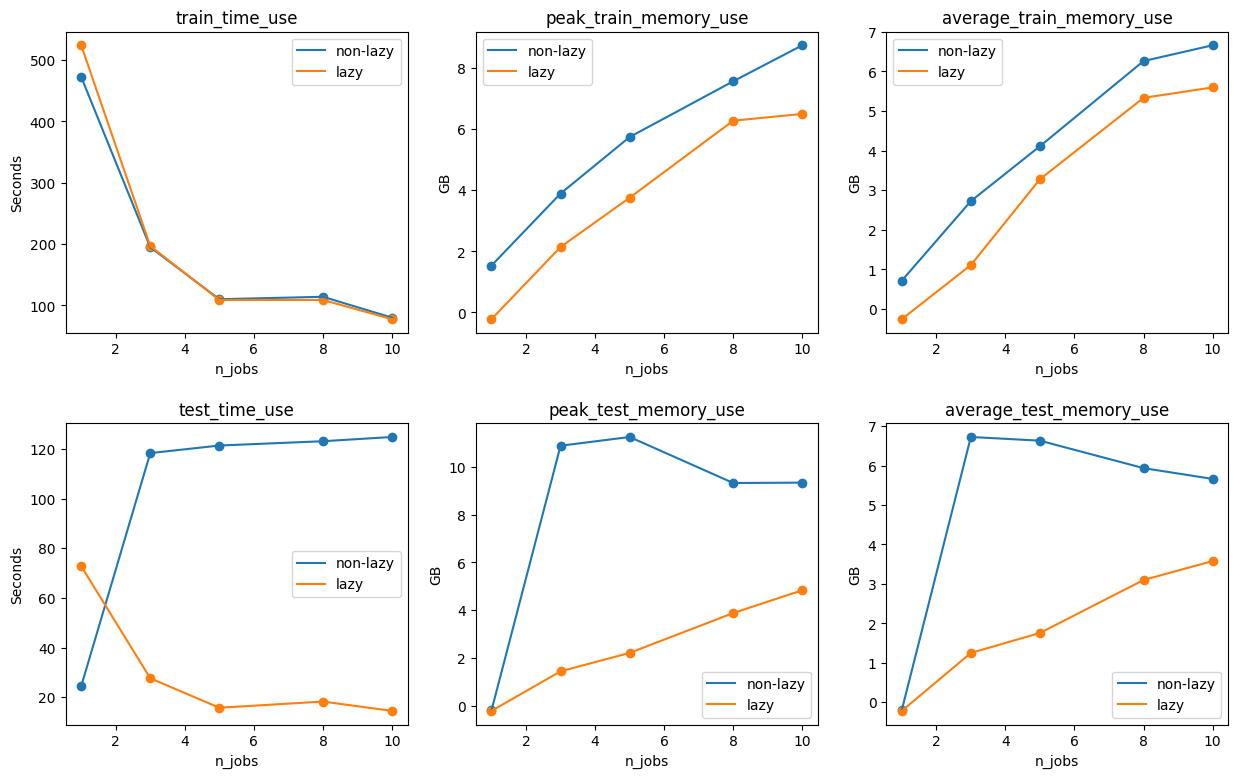

In [8]:
fig,ax = plt.subplots(2,3,figsize=(15,9))
for var_id, var_ in enumerate(['train_time_use','peak_train_memory_use','average_train_memory_use',
             'test_time_use','peak_test_memory_use','average_test_memory_use']):
    ax[var_id//3, var_id%3].plot(
        log_df[log_df['lazy_loading']==False]['n_jobs'],
        log_df[log_df['lazy_loading']==False][var_],
        label='non-lazy'
    )
    ax[var_id//3, var_id%3].scatter(
        log_df[log_df['lazy_loading']==False]['n_jobs'],
        log_df[log_df['lazy_loading']==False][var_],
    )

    ax[var_id//3, var_id%3].plot(
        log_df[log_df['lazy_loading']==True]['n_jobs'],
        log_df[log_df['lazy_loading']==True][var_],
        label='lazy'
    )
    ax[var_id//3, var_id%3].scatter(
        log_df[log_df['lazy_loading']==True]['n_jobs'],
        log_df[log_df['lazy_loading']==True][var_],
    )

    ax[var_id//3, var_id%3].legend()
    ax[var_id//3, var_id%3].set_title(var_)
    if 'time' in var_:
        ax[var_id//3, var_id%3].set_ylabel('Seconds')
    elif 'memory' in var_:
        ax[var_id//3, var_id%3].set_ylabel('GB')
    ax[var_id//3, var_id%3].set_xlabel('n_jobs')


plt.subplots_adjust(wspace=0.2, hspace=0.3)


Still, the memory use will proportionally increase when n_jobs increase. That is because
1. Your data is being copied n_jobs times -- once for each processor, because data cannot be shared among processors. This problem cannot be solved by lazy loading, but can be solved by using database query (see the other notebook for how to use duckdb as input).
2. The trained models also cost memory. For non-lazy loading, all trained models are saved in memory, so a 10-ensemble model means 10 times more models, therefore memory, than a 1-ensemble model. Despite that, lazy-loading still managed to reduce this memory load by only allowing ~1 models in memory per ensemble (so still proportional to the number of ensembles), and ask that if the model has finished training or predicting, auto-dump itself to disk.
3. Lazy-loading also seems to dramatically reduce the prediction time. This means that avoiding serializing huge amount of data (models) with joblib is more important than I/O overhead in single model reading/dumping.

## Concluding mark

**Please open an issue if you have any question**

**Cheers!**


In [27]:
from watermark import watermark
print(watermark())
print(watermark(packages="stemflow,numpy,scipy,pandas,xgboost,tqdm,matplotlib,h3pandas,geopandas,scikit-learn"))


Last updated: 2025-10-11T10:38:34.910449-05:00

Python implementation: CPython
Python version       : 3.11.11
IPython version      : 8.31.0

Compiler    : Clang 18.1.8 
OS          : Darwin
Release     : 24.6.0
Machine     : arm64
Processor   : arm
CPU cores   : 14
Architecture: 64bit

stemflow    : 1.1.5
numpy       : 1.26.4
scipy       : 1.16.1
pandas      : 2.2.3
xgboost     : 3.0.4
tqdm        : 4.65.0
matplotlib  : 3.10.0
h3pandas    : 0.3.0
geopandas   : 1.0.1
scikit-learn: 1.5.2

